In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [17]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import asf_search as asf
from datetime import datetime, date, timedelta, timezone
from typing import List
from pystac_client import Client, ItemSearch
import geopandas as gpd
from rasterio.crs import CRS
import contextily as cx
import pandas as pd
from shapely.ops import unary_union
from itertools import combinations
import opera_coverage
# from opera_coverage import search as s

[autoreload of opera_coverage.coverage failed: Traceback (most recent call last):
  File "/Users/angelac/miniconda3/envs/opera_coverage/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/angelac/miniconda3/envs/opera_coverage/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/angelac/miniconda3/envs/opera_coverage/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/angelac/opera_coverage/opera_coverage/coverage.py", line 4, in <module>
    from opera_coverage import formatting as f
ImportError: cannot import name 'formatting' from 'opera_coverage' (/Us

In [21]:
from importlib import reload
reload(p)

<module 'plotting' from '/Users/angelac/ground-swath/Angela_notebooks/plotting.py'>

In [ ]:
def get_coverage(sensor: List[str], aoi: Point, date: List[datetime] = None) -> List[dict]:
    """
    Sensor: choose sentinel1, sentinel2, landsat8
    AOI: enter coordinates as Polygon object
    date: leave as none if searching today, else enter time range as datetime tuple: datetime(YYYY,MM,DD)
    """
    freq = {}
    next_acq = {}
    area = {}
    
    for sensor_name in sensor:
        freq[sensor_name] = ''
        next_acq[sensor_name] = ''
        area[sensor_name] = ''
        
        if 'landsat8' in sensor_name.lower():
            results = s.hls_search('landsat8', aoi, date)
            df = f.format_results_for_hls(results,'landsat8')
        elif 'sentinel1' in sensor_name.lower():
            results = s.asf_search(aoi, date)
            df = f.format_results_for_sent1(results)
        elif 'sentinel2' in sensor_name.lower():
            results = s.hls_search('sentinel2', aoi, date)
            df = f.format_results_for_hls(results,'sentinel2')
        
        df = df.dissolve(by='startTime').reset_index()
        
#         if df.startTime[0] == df.startTime[1] or df.startTime[-2] == df.startTime[-1]:
        df = f.drop(df)
        
        # return cadence as string or list using get_cadence
        freq[sensor_name] = s.get_cadence(df)
        
        # find next acquisition time, if search time is today then returns 'N/A'
        if date == None:
            next_acq[sensor_name] = 'N/A'
            
        else:
            next_acq[sensor_name] = s.acq_search(sensor_name.lower(), aoi, date[1])
        
        # find area intersection for each sensor
#         coords = [Polygon(c) for c in coords]
#         area[sensor_name] = unary_union([a.intersection(b) for a, b in combinations(coords, 2)])
        
        if len(results) == 0:
            area[sensor_name] = 0
        else:
            area[sensor_name] = df.geometry[0]
            
            if len(results) > 1:
                
                for i in range(len(df) - 1):
                    area[sensor_name] = area[sensor_name].intersection(df.geometry[i + 1])
         
    return freq, next_acq, area

### Polygons of areas of interest:

Ridgecrest coordinates: Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])

Wax lake delta: Polygon([[-91.4964, 29.4641],[-91.3849, 29.4641],[-91.3849, 29.5627],[-91.4964, 29.5627],[-91.4964, 29.4641]])

Laurentides forest in Canada: Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])

In [14]:
# create shapely and geodataframe files of areas of interest
ridgecrest = Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])
waxlake = Polygon([[-91.4964, 29.4641],[-91.3849, 29.4641],[-91.3849, 29.5627],[-91.4964, 29.5627],[-91.4964, 29.4641]])
laurentides = Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])
ridgecrest_df = opera_coverage.formatting.shape2gdf(ridgecrest, 'ridgecrest')
waxlake_df = shape2gdf(waxlake, 'waxlake')
laurentides_df = shape2gdf(laurentides, 'laurentides')

NameError: name 'opera_coverage' is not defined

In [5]:
%%time
freq1, next_acq1, area1 = get_coverage(['sentinel1','sentinel2','landsat8'],ridgecrest,[datetime(2022,1,1), datetime(2022,2,1)])


CPU times: user 299 ms, sys: 32.2 ms, total: 331 ms
Wall time: 29.3 s


In [6]:
freq2, next_acq2, area2 = get_coverage(['sentinel1','sentinel2','landsat8'],waxlake,[datetime(2022,1,1), datetime(2022,2,1)])


In [7]:
freq3, next_acq3, area3 = get_coverage(['sentinel1','sentinel2','landsat8'],laurentides,[datetime(2022,1,1), datetime(2022,2,1)])


In [ ]:
reload(f)

In [8]:
print(freq1['landsat8'])
print(next_acq1['landsat8'])
print(freq1['sentinel1'])
print(next_acq1['sentinel1'])
print(freq1['sentinel2'])
print(next_acq1['sentinel2'])

['15 days, 23:59:54.921000']
2022-02-15T18:28:00.390Z
['12:01:18', '11 days, 11:58:42', '12:01:18', '11 days, 11:58:41', '12:01:18']
2022-02-06 01:50:59+00:00
['5 days, 0:00:05.383000', '9 days, 23:59:58.835000', '4 days, 23:59:54.328000', '5 days, 0:00:05.554000']
2022-02-02T18:44:24.938Z


In [9]:
print(freq2['landsat8'])
print(next_acq2['landsat8'])
print(freq2['sentinel1'])
print(next_acq2['sentinel1'])
print(freq2['sentinel2'])
print(next_acq2['sentinel2'])

Only one acquisition on 2022-01-16T16:38:29.896Z
2022-02-01T16:38:25.254Z
['23 days, 23:59:59']
2022-02-06 00:10:26+00:00
['4 days, 23:59:54.374000', '19 days, 23:59:58.110000']
2022-02-09T16:55:25.514Z


In [10]:
print(freq3['landsat8'])
print(next_acq3['landsat8'])
print(freq3['sentinel1'])
print(next_acq3['sentinel1'])
print(freq3['sentinel2'])
print(next_acq3['sentinel2'])

['7 days, 0:06:09.592000', '8 days, 23:53:45.752000', '7 days, 0:06:09.381000']
2022-02-09T15:44:10.497Z
['11 days, 23:59:59']
2022-02-03 22:52:35+00:00
['4 days, 23:59:54.343000', '1 day, 23:50:08.985000', '3 days, 0:09:55.962000', '1 day, 23:49:58.458000', '3 days, 0:09:55.955000', '1 day, 23:50:08.248000', '3 days, 0:09:56.423000', '1 day, 23:49:57.882000', '3 days, 0:09:55.919000', '1 day, 23:50:09.988000']
2022-02-04T16:00:15.136Z


### Work in progress

In [17]:
land8_forest = f.format_results_for_hls(d,'landsat8')

In [18]:
df_dis = land8_forest.dissolve(by='datetime').reset_index()

,datetime,geometry,start_datetime,end_datetime,eo:cloud_cover,sensor,startTime,stopTime
0,2022-01-08T15:44:18.159Z,"POLYGON ((-73.55749 46.94462, -73.58334 45.956...",2022-01-08T15:44:18.159Z,2022-01-08T15:44:42.038Z,27,landsat8,2022-01-08 15:44:18.159000+00:00,2022-01-08 15:44:42.038000+00:00
1,2022-01-15T15:50:27.751Z,"POLYGON ((-74.87403 45.96548, -76.29100 45.958...",2022-01-15T15:50:27.751Z,2022-01-15T15:50:51.633Z,24,landsat8,2022-01-15 15:50:27.751000+00:00,2022-01-15 15:50:51.633000+00:00
2,2022-01-24T15:44:13.503Z,"POLYGON ((-73.55749 46.94462, -73.58334 45.956...",2022-01-24T15:44:13.503Z,2022-01-24T15:44:37.390Z,98,landsat8,2022-01-24 15:44:13.503000+00:00,2022-01-24 15:44:37.390000+00:00
3,2022-01-31T15:50:22.884Z,"POLYGON ((-76.29100 45.95826, -76.31456 46.946...",2022-01-31T15:50:22.884Z,2022-01-31T15:50:46.762Z,27,landsat8,2022-01-31 15:50:22.884000+00:00,2022-01-31 15:50:46.762000+00:00


In [ ]:
a = df_dis.concat(sent2_forest)
a

In [ ]:
test = sent1_forest.startTime[0]

In [ ]:
world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10,10))

In [ ]:
world.dissolve(by='continent').plot(figsize=(10,10))
# world.plot()

### The below cells are just for reminding what format the output results have

In [11]:
wkt = laurentides.wkt
opts = {
    'platform': asf.PLATFORM.SENTINEL1,
    'processingLevel': [asf.PRODUCT_TYPE.SLC],
    'beamMode': [asf.BEAMMODE.IW],
    'start': '2022-01-01T00:00:00Z',
    'end': '2022-02-01T23:59:59Z'
}
results = asf.search(intersectsWith=wkt,**opts)
print(len(results))

2


In [12]:
sent1_forest = f.format_results_for_sent1(results)

In [15]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0']
search_params = {"collections": hls_collections,
                 "bbox": [-75.0327, 46.0832, -74.8823, 46.1914], # list of xmin, ymin, xmax, ymax
                 "datetime": [datetime(2022,1,1), datetime(2022,2,1)],
                 }
search_hls = api.search(**search_params)
hls_collection = search_hls.get_all_items()
d = list(hls_collection)
# d[0].properties

In [14]:
sent2_forest = f.format_results_for_hls(g,'sentinel2')

In [25]:
sent2_forest = f.drop(sent2_forest)

In [ ]:
d[1].to_dict()

In [ ]:
df.iloc[:2].to_file('test2.geojson',driver='GeoJSON')

In [ ]:
shape(area1['sentinel1'])

# Visualization

In [19]:
import plotting as p

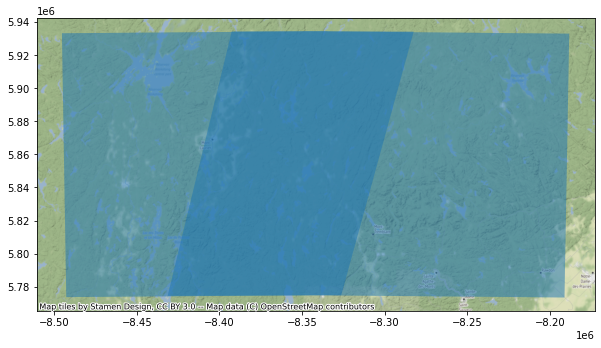

In [20]:
p.visual(df_dis.geometry)

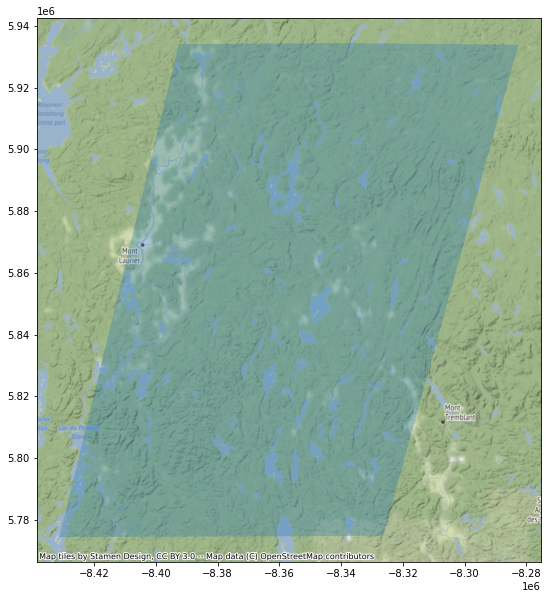

In [23]:
p.find_overlap(df_dis.geometry)

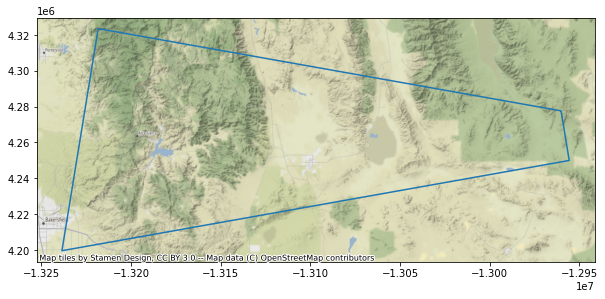

In [24]:
p.visual(area1['sentinel1'],outline=True)

In [ ]:
p.visual(area1['sentinel1'])

In [ ]:
p.visual(area1)

In [ ]:
p.visual(area2)

In [ ]:
p.visual(area3)

### Deprecated